In the first notebook of our custom `RxnTools` package, we looked into extracting the atom-map numbers of atoms undergoing any transformation within an input atom-mapped reaction. In the second notebook, we dove into the nuances of externally supplied atom-map numbers vs RDKit's internal atom indices and how to extract templates around a given reaction site with these nuances in mind. In the third notebook, we explored extracting templates of varying radii as well as with and without stereochemistry for a single monosubstrate reaction, such as an alcohol dehydrogenase reaction or a nitrilase reaction.

Here, in this fourth notebook, we will explore extracting reaction templates from several hundred monosubstrate reactions in the BRENDA database, which has been fully atom-mapped by the EnzymeMap database publication (https://pubs.rsc.org/en/content/articlehtml/2023/sc/d3sc02048g). We will then group common templates, and consequently, their original reactions together and visualize which substrates fall into which clusters.

In [30]:
import json
import numpy as np
import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Draw, rdChemReactions
from rxntools import reaction, utils, draw
from typing import List 
from IPython.display import display
import ipywidgets as widgets
import mols2grid

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500 # Resolution of figures
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.loc"] = 'best'
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [31]:
with open('../data/cofactors.json') as f:
    cofactors_dict = json.load(f)
cofactors_list = [cofactors_dict[key] for key in cofactors_dict.keys()]

In [32]:
JN1224_df = pd.read_csv('../data/JN1224MIN_rules.tsv',delimiter = '\t')
BRENDA_df = pd.read_csv('../data/enzymemap_v2_brenda2023.csv')

#### Visualize JN reaction rules and EnzymeMap reactions dataframes

In [33]:
JN1224_df.head(5)

,Name,Reactants,SMARTS,Products,Comments
0,rule0001,Any;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;Any,A0A060PLD9;A0A0P0YNP7;A0A0P9RZM9;A1XCQ0;A3E242...
1,rule0002,Any;NAD_CoF,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,NADH_CoF;Any,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
2,rule0003,NADH_CoF;Any,[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,Any;NAD_CoF,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
3,rule0004,Any;NADH_CoF;O2,[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6...,Any;NAD_CoF;WATER,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...
4,rule0005,Any;NAD_CoF;WATER,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,Any;NADH_CoF;O2,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...


In [34]:
BRENDA_df.head(3)

,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num
0,0,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,acetaldehyde + NADH + H+ = ethanol + NAD+ {r},[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,0,direct,single,0.991708,True,Saccharomyces cerevisiae,[],NaN,1.1.1.1
1,0,[CH3:1][CH2:2][OH:3].[NH2:4][C:5](=[O:6])[c:7]...,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...,acetaldehyde + NADH + H+ = ethanol + NAD+ {r},[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,0,direct reversed,single,0.991708,True,Saccharomyces cerevisiae,[],NaN,1.1.1.1
2,1,[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[...,CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O...,acetaldehyde + NADH + H+ = ethanol + NAD+ {r},[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,0,direct,single,0.991708,True,Ogataea angusta,['H9ZGN0'],uniprot,1.1.1.1


#### Select reaction rule for which to extract reactions from EnzymeMap

Here, we begin the process of extracting new reaction templates/ intermediate rules from reactions that fall within a specified general rule. Once the `query_rule` argument is set, the rest of this notebook will extract reaction templates/ intermediate rules from all reactions mapped to this general `query_rule`. Reactions that lead to identifical templates will be grouped together, i.e., they will fall under the same intermediate rule.

Instead of querying reactions under a given generalized rule, it is also possible to query reactions with an EC number using the `query_ec` argument. All decarboxylases begin with the EC number `4.1.1.` while all alcohol dehydrogenases begin with the EC number `1.1.1.`.

In [49]:
query_rule = 'rule0024'
query_ec = None #'4.1.1.' 
query_rxns_frm_BRENDA = None # always set to None first

if query_rule:
    
    rxn_rule_SMARTS = list(JN1224_df[JN1224_df['Name'] == query_rule]['SMARTS'])[0]

    # when indexing reactions from BRENDA, we only take the forward direction by setting source == direct
    query_rxns_frm_BRENDA = set(BRENDA_df[ (BRENDA_df['rule'] == rxn_rule_SMARTS) & (BRENDA_df['source'] == 'direct') ]['mapped'])
    print(f'\nThere are {len(query_rxns_frm_BRENDA)} unique reactions within BRENDA under rule {query_rule}\n')

if query_ec:

    keep_idx = []
    
    for i, ec_num in enumerate(list(BRENDA_df['ec_num'])):
        if ec_num[0:6] == '4.1.1.':
            keep_idx.append(i)

    query_df = BRENDA_df.iloc[keep_idx, :]
    query_df = query_df[query_df['source']=='direct']
    query_rxns_frm_BRENDA = set(query_df['mapped'])
    print(f'\nThere are {len(query_rxns_frm_BRENDA)} unique reactions within BRENDA under EC number {query_ec}\n')


There are 420 unique reactions within BRENDA under rule rule0024



In [67]:
for i,rxn_str in enumerate(list(BRENDA_df['unmapped'])):
    reactants, products = rxn_str.split('>>')
    print(products.split('.'))
    break

['CCO', 'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1']


#### Scroll through extracted templates for each substrate

In [50]:
list_length = len(list(query_rxns_frm_BRENDA)) 

radius_widget = widgets.IntSlider(value=1, min=1, max=4, step=1, description='Radius')

index_widget = widgets.Dropdown(options=list(range(list_length)), value=1, description='Index')

stereo_widget = widgets.Checkbox(value=True, description='Include Stereo')

def update_reaction(index, radius, include_stereo):
    
    rxn_SMARTS = list(query_rxns_frm_BRENDA)[index]

    mapped_rxn = reaction.mapped_reaction(rxn_smarts = rxn_SMARTS)
    changed_atoms, broken_bonds, formed_bonds = mapped_rxn.get_all_changed_atoms(include_cofactors = False,
                                                                                 consider_stereo = include_stereo,
                                                                                 cofactors_list = cofactors_list)
    
    print(f'\nChanged atoms: {changed_atoms}')

    rxn = AllChem.ReactionFromSmarts(rxn_SMARTS)
    reactants = rxn.GetReactants()
    products = rxn.GetProducts()

    # iterate over all reactant mols
    for reactant_mol in reactants:

        # if reactant is a cofactor, do not extract any templates
        if utils.is_cofactor(mol = reactant_mol, cofactors_list = cofactors_list, consider_stereo = include_stereo):
            pass
        
        # if reactant is not a cofactor, then extract templates
        else:
            substrate_mol = Chem.MolFromSmiles(Chem.MolToSmiles(reactant_mol))
            print(f'\nSubstrate SMARTS: {Chem.MolToSmarts(reactant_mol)}')
            substrate_template = mapped_rxn.get_template_around_rxn_site(
                                                            atom_mapped_substrate_smarts = Chem.MolToSmarts(reactant_mol),
                                                            reactive_atom_indices = list(changed_atoms),
                                                            radius = radius,
                                                            include_stereo = include_stereo)
            break

    # iterate over all product mols
    for product_mol in products:
        
        # if product is a cofactor, do not extract any templates
        if utils.is_cofactor(mol = product_mol, cofactors_list = cofactors_list, consider_stereo = include_stereo):
            pass
        
        # if product is not a cofactor, then extract templates
        else:
            print(f'\nProduct SMARTS: {Chem.MolToSmarts(product_mol)}')
            break

    print(f'\nExtracted template: {substrate_template}')
    print(f'\nFinal template: {utils.reset_atom_map(substrate_template, starting_atom_num = 1)}')
    
    print(f'\nSubstructure matches found in substrate with final template: {substrate_mol.HasSubstructMatch(Chem.MolFromSmarts(substrate_template), 
                                                                                               useChirality = True)}\n')
    
    svg = draw.highlight_substructures_in_notebook(
        substrate_smarts = Chem.MolToSmiles(reactant_mol),
        substructure_smarts = substrate_template,
        allow_multiple_matches = True)

    display(svg)

    # display the full atom-mapped reaction as well
    display(AllChem.ReactionFromSmarts(rxn_SMARTS))
    
# create an interactive output with widgets
interactive_plot = widgets.interactive(update_reaction,
                                       index = index_widget,
                                       radius = radius_widget,
                                       include_stereo = stereo_widget)

display(interactive_plot)


interactive(children=(Dropdown(description='Index', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

#### Scroll through extracted templates for each substrate and its corresponding product

In [51]:
list_length = len(list(query_rxns_frm_BRENDA)) 

# create interactive widgets
radius_widget = widgets.IntSlider(value=1, min=1, max=4, step=1, description='Radius')
index_widget = widgets.Dropdown(
    options=list(range(list_length)),
    value=1,
    description='Index'
)
stereo_widget = widgets.Checkbox(value=True, description='Include Stereo')

# function to update output based on widget values
def update_reaction(index, radius, include_stereo):
    rxn_SMARTS = list(query_rxns_frm_BRENDA)[index]
    rxn = AllChem.ReactionFromSmarts(rxn_SMARTS)
    reactants = rxn.GetReactants()
    products = rxn.GetProducts()

    mapped_rxn = reaction.mapped_reaction(rxn_smarts=rxn_SMARTS)
    changed_atoms, broken_bonds, formed_bonds = mapped_rxn.get_all_changed_atoms(
        include_cofactors=False,
        consider_stereo=include_stereo,
        cofactors_list=cofactors_list)
    
    print(f'\nChanged atoms: {changed_atoms}')

    # iterate over all reactant mols
    for reactant_mol in reactants:
        if utils.is_cofactor(mol=reactant_mol, cofactors_list=cofactors_list, consider_stereo=include_stereo):
            pass
        else:
            substrate_mol = Chem.MolFromSmiles(Chem.MolToSmiles(reactant_mol))
            print(f'\nSubstrate SMARTS: {Chem.MolToSmarts(reactant_mol)}')
            substrate_template = mapped_rxn.get_template_around_rxn_site(
                                                            atom_mapped_substrate_smarts = Chem.MolToSmarts(reactant_mol),
                                                            reactive_atom_indices = list(changed_atoms),
                                                            radius = radius,
                                                            include_stereo = include_stereo)
            break

    # iterate over all product mols
    for product_mol in products:
        if utils.is_cofactor(mol=product_mol, cofactors_list=cofactors_list, consider_stereo=include_stereo):
            pass
        else:
            print(f'\nProduct SMARTS: {Chem.MolToSmarts(product_mol)}')
            product_template = mapped_rxn.get_template_around_rxn_site(
                                                            atom_mapped_substrate_smarts = Chem.MolToSmarts(product_mol),
                                                            reactive_atom_indices = list(changed_atoms),
                                                            radius = radius,
                                                            include_stereo = include_stereo)
            break

    print(f'\nFinal template: {reset_smarts_numbering(substrate_template)} >> {reset_smarts_numbering(product_template)}')
    
    svg = draw.highlight_substructures_in_notebook(
        substrate_smarts = Chem.MolToSmiles(reactant_mol),
        substructure_smarts = substrate_template,
        allow_multiple_matches = True)

    display(svg)
    
    svg = draw.highlight_substructures_in_notebook(
        substrate_smarts = Chem.MolToSmiles(product_mol),
        substructure_smarts = product_template,
        allow_multiple_matches = True)

    display(svg)

    display(AllChem.ReactionFromSmarts(rxn_SMARTS))

# use widgets to create an interactive output
interactive_plot = widgets.interactive(
    update_reaction,
    index = index_widget,
    radius = radius_widget,
    include_stereo = stereo_widget
)

display(interactive_plot)


interactive(children=(Dropdown(description='Index', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

#### Scroll through each resulting cluster/ group of substrates with identical templates

In [52]:
radius = 1
include_stereo = True

all_rxn_SMARTS_list = list(query_rxns_frm_BRENDA)

all_templates = []
all_substrates = []

# for each reaction under the specified reaction rule
for rxn_SMARTS in all_rxn_SMARTS_list:
    
    rxn = AllChem.ReactionFromSmarts(rxn_SMARTS)
    reactants = rxn.GetReactants()
    products = rxn.GetProducts()
    
    mapped_rxn = reaction.mapped_reaction(rxn_smarts = rxn_SMARTS)

    changed_atoms, broken_bonds, formed_bonds = mapped_rxn.get_all_changed_atoms(include_cofactors = False,
                                                                                 consider_stereo = include_stereo,
                                                                                 cofactors_list = cofactors_list)

    # iterate over all reactant mols
    for reactant_mol in reactants:

        # do nothing if a reactant is a cofactor according to our predetermined list of cofactors
        if utils.is_cofactor(mol=reactant_mol, cofactors_list=cofactors_list, consider_stereo=include_stereo):
            pass

        # if reactant is a substrate, however, extract the chemical environment surrounding the reactive sites
        else:
            substrate_mol = Chem.MolFromSmiles(Chem.MolToSmiles(reactant_mol))
            
            substrate_template = mapped_rxn.get_template_around_rxn_site(
                                                            atom_mapped_substrate_smarts = Chem.MolToSmarts(reactant_mol),
                                                            reactive_atom_indices = list(changed_atoms),
                                                            radius = radius,
                                                            include_stereo = include_stereo)

            substrate_template = reset_smarts_numbering(substrate_template)

            all_templates.append(substrate_template)
            all_substrates.append(Chem.MolToSmiles(reactant_mol))
            break

# create a dataframe
grouped_rxns_df = pd.DataFrame({'Substrate SMILES': all_substrates,
                                'Template': all_templates})

In [53]:
# create a naming system for the reaction rules
unique_templates = set(all_templates)
template_names_list = [ f'{query_rule}_r{radius}_{i}' for i in range(len(unique_templates)) ]
template_names_df = pd.DataFrame({'Template': list(unique_templates),
                                 'Template name': template_names_list})

In [54]:
template_names_df

,Template,Template name
0,[C:1][C&H2:2][C@@&H1:3]([O&H1:4])[C:5],rule0024_r1_0
1,[C&H3:1][C@:2]([O&H1:3])([C:4])[C@@&H1:5]([C&H...,rule0024_r1_1
2,[C&H3:1][C@@&H1:2]([O&H1:3])[C@@&H1:4]([O&H1:5...,rule0024_r1_2
3,[C&H1:1]([C@&H1:2])([O&H1:3])[C&H2:4][C:5],rule0024_r1_3
4,[C&H3:1][C@@&H1:2]([O&H1:3])[C&H2:4][C:5],rule0024_r1_4
...,...,...
194,[C&H2:1][C&H1:2]([O&H1:3])[C:4]#[N:5],rule0024_r1_194
195,[N&H2:1][C@&H1:2]([C:3](=[O:4])[O&H1:5])[C&H1:6],rule0024_r1_195
196,[C&H3:1][C:2]([C&H3:3])([C&H2:4][O:5][P:6](=[O...,rule0024_r1_196
197,[C&H3:1][C:2]([C&H3:3])([C&H2:4][O:5][P:6](=[O...,rule0024_r1_197


In [55]:
grouped_rxns_df

,Substrate SMILES,Template
0,[O:1]=[C:2]([OH:3])/[CH:4]=[CH:5]/[CH2:6][C:7]...,[O:1]=[C:2]([O&H1:3])-[C&H1:4]=[C&H1:5]
1,[CH3:1][C@H:2]([OH:3])[CH2:4][C:5](=[O:6])[C:7...,[C&H3:1][C@&H1:2]([O&H1:3])[C&H2:4][C:5]
2,[O:1]=[C:2]([OH:3])/[CH:4]=[CH:5]/[c:6]1[cH:7]...,[O:1]=[C:2]([O&H1:3])-[C&H1:4]=[C&H1:5]
3,[NH2:1][C@H:2]([C:3](=[O:4])[OH:5])[C@H:6]([OH...,[N&H2:1][C@&H1:2]([C:3])[C@&H1:4]([O&H1:5])[C&...
4,[O:1]=[C:2]([OH:3])[C:4](=[O:5])[CH2:6][C@H:7]...,[C:1][C&H2:2][C@&H1:3]([O&H1:4])[C@&H1:5]
...,...,...
412,[CH3:1][N+:2]([CH3:3])([CH3:4])[CH2:5][CH:6]([...,[C&H1:1][C&H2:2][C:3](=[O:4])[O&H1:5]
413,[CH3:1][C:2]([C:3](=[O:4])[OH:5])([C:6](=[O:7]...,[C&H3:1][C:2]([C:3](=[O:4])[O&H1:5])([C:6])[c:7]
414,[NH2:1][C@@H:2]([CH2:3][c:4]1[cH:5][cH:6][cH:7...,[N&H2:1][C@@&H1:2]([C&H2:3])[C:4](=[O:5])[O&H1:6]
415,[CH3:1][c:2]1[cH:3][cH:4][c:5]([C:6]([OH:7])([...,[c:1][C:2]([O&H1:3])([C:4](=[O:5])[O&H1:6])[C:7]


In [56]:
# Assuming your DataFrames are named template_names_df and grouped_rxns_df
# Perform the merge operation
merged_df = grouped_rxns_df.merge(template_names_df[['Template', 'Template name']], 
                                  on='Template', 
                                  how='left')

In [57]:
merged_df

,Substrate SMILES,Template,Template name
0,[O:1]=[C:2]([OH:3])/[CH:4]=[CH:5]/[CH2:6][C:7]...,[O:1]=[C:2]([O&H1:3])-[C&H1:4]=[C&H1:5],rule0024_r1_39
1,[CH3:1][C@H:2]([OH:3])[CH2:4][C:5](=[O:6])[C:7...,[C&H3:1][C@&H1:2]([O&H1:3])[C&H2:4][C:5],rule0024_r1_55
2,[O:1]=[C:2]([OH:3])/[CH:4]=[CH:5]/[c:6]1[cH:7]...,[O:1]=[C:2]([O&H1:3])-[C&H1:4]=[C&H1:5],rule0024_r1_39
3,[NH2:1][C@H:2]([C:3](=[O:4])[OH:5])[C@H:6]([OH...,[N&H2:1][C@&H1:2]([C:3])[C@&H1:4]([O&H1:5])[C&...,rule0024_r1_164
4,[O:1]=[C:2]([OH:3])[C:4](=[O:5])[CH2:6][C@H:7]...,[C:1][C&H2:2][C@&H1:3]([O&H1:4])[C@&H1:5],rule0024_r1_69
...,...,...,...
412,[CH3:1][N+:2]([CH3:3])([CH3:4])[CH2:5][CH:6]([...,[C&H1:1][C&H2:2][C:3](=[O:4])[O&H1:5],rule0024_r1_77
413,[CH3:1][C:2]([C:3](=[O:4])[OH:5])([C:6](=[O:7]...,[C&H3:1][C:2]([C:3](=[O:4])[O&H1:5])([C:6])[c:7],rule0024_r1_57
414,[NH2:1][C@@H:2]([CH2:3][c:4]1[cH:5][cH:6][cH:7...,[N&H2:1][C@@&H1:2]([C&H2:3])[C:4](=[O:5])[O&H1:6],rule0024_r1_30
415,[CH3:1][c:2]1[cH:3][cH:4][c:5]([C:6]([OH:7])([...,[c:1][C:2]([O&H1:3])([C:4](=[O:5])[O&H1:6])[C:7],rule0024_r1_142


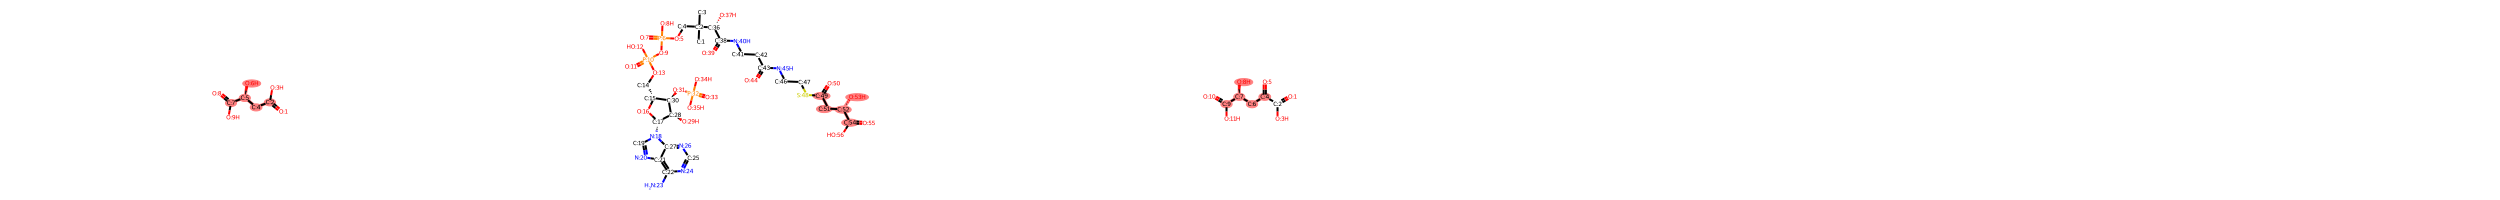

In [58]:
index = 11

template_name = template_names_df.iloc[index, 1]
template_SMARTS = list(merged_df[merged_df['Template name'] == template_name]['Template'])[0]
substrates_SMILES_list = merged_df[merged_df['Template name'] == template_name]['Substrate SMILES']

mols = [Chem.MolFromSmiles(s) for s in substrates_SMILES_list]
highlight_template = [m.GetSubstructMatch(Chem.MolFromSmarts(template_SMARTS)) for m in mols]

Draw.MolsToGridImage(mols = mols,
                             molsPerRow = 5,
                             subImgSize = (500, 200),
                             highlightAtomLists = highlight_template)

In [59]:
def display_grid(index):
    # Get the template name and SMARTS based on the current index
    template_name = template_names_df.iloc[index, 1]
    template_SMARTS = list(merged_df[merged_df['Template name'] == template_name]['Template'])[0]
    substrates_SMILES_list = merged_df[merged_df['Template name'] == template_name]['Substrate SMILES']
    
    # Generate molecules and highlights
    mols = [Chem.MolFromSmiles(s) for s in substrates_SMILES_list]
    highlight_template = [m.GetSubstructMatch(Chem.MolFromSmarts(template_SMARTS)) for m in mols]

    print(f'\nTemplate: {template_SMARTS}\n')
    
    # Display the molecules grid
    img = Draw.MolsToGridImage(mols=mols,
                               molsPerRow=5,
                               subImgSize=(500, 200),
                               highlightAtomLists=highlight_template)
    display(img)

# Create the slider widget
slider = widgets.IntSlider(
    value=0,  # Default index
    min=0,  # Start index
    max=len(template_names_df) - 1,  # End index
    step=1,  # Step size
    description='Index:',
    continuous_update=False  # Update only when the slider stops moving
)

# Create an interactive widget and display it
interactive_widget = widgets.interactive(display_grid, index=slider)
display(interactive_widget)


interactive(children=(IntSlider(value=0, continuous_update=False, description='Index:', max=198), Output()), _…

#### Tally up the total number of templates extracted

In [ ]:
def count_templates_for_monosubstrate_rxns(radius: int, include_stereo: bool, query_rxns: any) -> int:

    all_templates = []
    
    for index, _ in enumerate(query_rxns):
    
        rxn_SMARTS = list(query_rxns)[index]
        rxn = AllChem.ReactionFromSmarts(rxn_SMARTS)
        reactants = rxn.GetReactants()
        products = rxn.GetProducts()
    
        mapped_rxn = reaction.mapped_reaction(rxn_smarts=rxn_SMARTS)
        changed_atoms, broken_bonds, formed_bonds = mapped_rxn.get_all_changed_atoms(include_cofactors=False, 
                                                                                     consider_stereo=include_stereo,
                                                                                     cofactors_list=cofactors_list)
    
        for reactant_mol in reactants:
            if utils.is_cofactor(mol=reactant_mol, cofactors_list=cofactors_list, consider_stereo=include_stereo):
                pass
            else:
                substrate_mol = Chem.MolFromSmiles(Chem.MolToSmiles(reactant_mol))
                
                template = mapped_rxn.get_template_around_rxn_site(atom_mapped_substrate_smarts = Chem.MolToSmarts(reactant_mol),
                                                                   reactive_atom_indices = list(changed_atoms),
                                                                   radius = radius,
                                                                   include_stereo = include_stereo)
    
                template = reset_smarts_numbering(template)
                all_templates.append(template)
                break
    
    return len(set(all_templates))

In [ ]:
r1_wo_stereo = count_templates_for_monosubstrate_rxns(radius = 1, include_stereo = False, query_rxns = query_rxns_frm_BRENDA)
r1_w_stereo = count_templates_for_monosubstrate_rxns(radius = 1, include_stereo = True, query_rxns = query_rxns_frm_BRENDA)

r2_wo_stereo = count_templates_for_monosubstrate_rxns(radius = 2, include_stereo = False, query_rxns = query_rxns_frm_BRENDA)
r2_w_stereo = count_templates_for_monosubstrate_rxns(radius = 2, include_stereo = True, query_rxns = query_rxns_frm_BRENDA)

r3_wo_stereo = count_templates_for_monosubstrate_rxns(radius = 3, include_stereo = False, query_rxns = query_rxns_frm_BRENDA)
r3_w_stereo = count_templates_for_monosubstrate_rxns(radius = 3, include_stereo = True, query_rxns = query_rxns_frm_BRENDA)

r4_wo_stereo = count_templates_for_monosubstrate_rxns(radius = 4, include_stereo = False, query_rxns = query_rxns_frm_BRENDA)
r4_w_stereo = count_templates_for_monosubstrate_rxns(radius = 4, include_stereo = True, query_rxns = query_rxns_frm_BRENDA)

In [ ]:
counts_wo_stereo = [r1_wo_stereo, r2_wo_stereo, r3_wo_stereo, r4_wo_stereo]
counts_w_stereo = [r1_w_stereo, r2_w_stereo, r3_w_stereo, r4_w_stereo]
radii = [1, 2, 3, 4]

x = np.arange(len(radii))  # Positions for each radius
bar_width = 0.4  # Width of each bar

fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis: counts
bars1 = ax1.bar(x - bar_width/2, counts_wo_stereo, bar_width, label='Without Stereochemistry')
bars2 = ax1.bar(x + bar_width/2, counts_w_stereo, bar_width, label='With Stereochemistry')

ax1.set_xlabel('Radius')
ax1.set_ylabel('Count', color='black')
ax1.set_title('Counts and Radii')
ax1.set_xticks(x)
ax1.set_xticklabels([f'Radius {r}' for r in radii])
ax1.legend(loc='upper left')
ax1.tick_params(axis='y', labelcolor='black')

plt.tight_layout()
plt.show()